In [ ]:
import sys
from pathlib import Path
import datetime as dt
import numpy as np 
import pandas as pd
import json
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score,  train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

ML_LOC = PROJPATH / "data/ML_2024"

#### Let's start with Nenana (or another location)

In [ ]:
location = "Koyukuk River at Bettles"
df = pd.read_csv(ML_LOC / f"DF/DF_{location.replace(' ', '_')}", index_col=0)
df.rename(columns={'t2m': 't2m_M', 'ssr': 'ssr_M', 'sd': 'sd_M'}, inplace=True)
Xy = df.loc[1980:2023, :].dropna()
# Xy.reset_index(inplace=True, names='year')
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
X_2024 = df.iloc[-1, :-1]
# X_2024 = df.reset_index(names='year').iloc[-1, :-1]

#### Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
X.columns

Index(['AO_DJ', 'AO_FM', 'EP-NP_DJ', 'EP-NP_FM', 'PNA_DJ', 'PNA_FM',
       'Nino1+2_DJ', 'Nino1+2_FM', 'Nino4_DJ', 'Nino4_FM', 'NPI_anom_FM',
       'NAO_DJ', 'NAO_FM', 'EA_DJ', 'EA_FM', 'WP_DJ', 'WP_FM', 'EA-WR_DJ',
       'EA-WR_FM', 'SCA_DJ', 'SCA_FM', 'POL_DJ', 'POL_FM',
       'seaice_ber_anom_DJ', 'seaice_ber_anom_FM', 'seaice_chuk_anom_DJ',
       'seaice_chuk_anom_FM', 'NenanaIceThick', 't2m_M', 'ssr_M', 'sd_M'],
      dtype='object')

In [ ]:

clf = ExtraTreesRegressor(n_estimators=200, random_state=42)
clf = clf.fit(X, y)
clf.feature_importances_
selector = SelectFromModel(clf, prefit=True)
X_new = X[X.columns[selector.get_support()]]
X_new

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1981,-0.989,0.000,-0.080,-0.170,0.315,0.990,-0.330,39.755556
1983,-1.187,-0.455,0.450,0.280,-0.705,-1.035,0.030,39.755556
1984,-1.345,-0.215,-0.830,-0.785,-0.620,-0.150,0.740,39.755556
1985,-0.444,-1.540,-0.795,-0.860,-0.350,-1.405,-0.120,39.755556
1986,-0.486,0.450,-0.245,-0.195,-0.130,-0.020,1.535,39.755556
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1988,-0.632,0.065,0.705,0.295,-0.215,0.730,-0.090,39.755556
1989,2.405,1.470,-1.745,-1.345,-0.200,0.165,0.790,42.000000
1990,3.196,-0.915,0.020,0.345,1.430,-0.645,0.070,36.000000
1991,-0.702,-0.035,0.615,0.440,0.425,0.550,0.175,38.000000


In [ ]:
X_new.corrwith(y)

AO_FM            -0.034828
EP-NP_FM          0.048603
Nino4_DJ         -0.388318
Nino4_FM         -0.391655
EA_FM            -0.214407
POL_DJ           -0.135978
POL_FM            0.162217
NenanaIceThick    0.092568
dtype: float64

Straight CV

In [ ]:
saveplots = True
summary = {}
summary['location'] = location
summary['predictors'] = list(X_new.columns)

In [ ]:
X_new

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1981,-0.989,0.000,-0.080,-0.170,0.315,0.990,-0.330,39.755556
1983,-1.187,-0.455,0.450,0.280,-0.705,-1.035,0.030,39.755556
1984,-1.345,-0.215,-0.830,-0.785,-0.620,-0.150,0.740,39.755556
1985,-0.444,-1.540,-0.795,-0.860,-0.350,-1.405,-0.120,39.755556
1986,-0.486,0.450,-0.245,-0.195,-0.130,-0.020,1.535,39.755556
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1988,-0.632,0.065,0.705,0.295,-0.215,0.730,-0.090,39.755556
1989,2.405,1.470,-1.745,-1.345,-0.200,0.165,0.790,42.000000
1990,3.196,-0.915,0.020,0.345,1.430,-0.645,0.070,36.000000
1991,-0.702,-0.035,0.615,0.440,0.425,0.550,0.175,38.000000


In [ ]:
# load model 
modeldir = ML_LOC / 'models'
filename = f"{location.replace(' ', '_')}_joblib_model.sav"
best_model = joblib.load(modeldir / filename)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chris/Projects/2023_Riverice/data/ML_2024/models/Koyukuk_River_at_Bettles_joblib_model.sav'

... or calculate it 

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=43)
model = GradientBoostingRegressor(random_state=40)
    # define search space
space = {
        'min_samples_leaf': list(range(4, 7)),
        # 'min_samples_leaf': [4],
        # 'min_samples_split': [3],
        # 'max_depth': [ 4],
        'min_samples_split': [2, 3, 4],
        'max_depth': [3, 4],
        'n_estimators': [500, 1000, 2000, 5000],
        'learning_rate': [0.01, 0.001, 0.0005, 0.0001],
        'subsample': [0.5, 0.7],
    }
# define search
search = GridSearchCV(model, space, cv=cv_inner, scoring='neg_mean_squared_error', verbose=1, 
            refit=True, n_jobs=6)
# execute search
grid_result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_model = grid_result.best_estimator_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev}, {param}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
-47.35404619768412, 9.375089508135439, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.5}
-48.21694643253992, 12.791187417020883, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.7}
-49.04170406416106, 8.603989903122276, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.5}
-49.5592072938562, 12.808692889356838, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.7}
-50.68852735246436, 9.076484231299805, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2000, 'subsample': 0.5}
-50.09795691597277, 12.985805578089975, {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min

In [ ]:
grid_result.cv_results_['mean_test_score'][grid_result.best_index_]

-41.67070617643579

In [ ]:
best_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.0001,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
summary['modelparams'] = best_model.get_params()
summary['rms_cv'] = np.sqrt(-grid_result.cv_results_['mean_test_score'][grid_result.best_index_])
summary['rms_std_cv'] = np.sqrt(grid_result.cv_results_['std_test_score'][grid_result.best_index_])

The mean squared error (MSE) on train set: 5.6877
The mean squared error (MSE) on test set: 48.9519
The score for this training set is 0.8574
The validation score for this test set is -0.2705
Pearson score on training set: 0.9781
Pearson score on test set: -0.0838



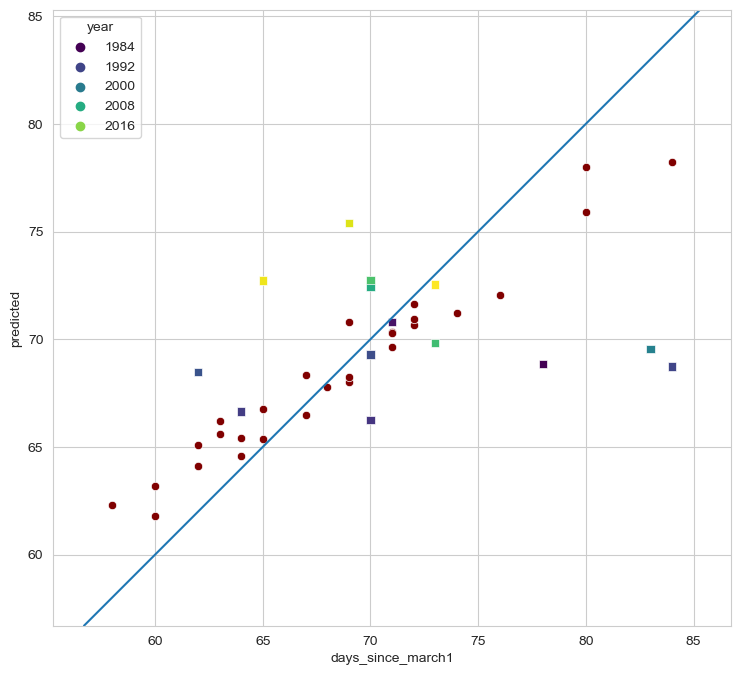

In [ ]:
random_seed = 2023
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=random_seed)

params_gb = {
        'min_samples_leaf': 2,
        'min_samples_split': 2,
        'max_depth': 3,
        # 'n_estimators': [250, 200, 150, 100],
        'n_estimators': 200,
        'learning_rate': 0.01,
        'subsample': 0.7,
    'random_state': random_seed, 
}
model1 = GradientBoostingRegressor(**params_gb)
model2 = RandomForestRegressor(random_state=random_seed)
model2 = best_model
model3 = ExtraTreesRegressor(n_estimators=200)
# define search
model = VotingRegressor(estimators=[('gb', model1), ('rf', model2), ('lr', model3)])
model = model1
# execute search
result = model.fit(X_train, y_train)
# get the best performing model fit on the whole training set
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)
# sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
# sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
# sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
# sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='maroon', ax=ax)
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, hue='year', marker='s', palette='viridis', ax=ax)
lims = ax.get_xlim()
ax.set_ylim(lims)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_aspect('equal')
plt.show(fig)
if saveplots:
    outdir = ML_LOC / "overfitting_tests"
    fn = f"{location.replace(' ', '_')}_overfit.png"
    fig.savefig(outdir / fn, bbox_inches='tight')

In [ ]:
# best_model = model1

In [ ]:
model.score(X_new, y)

0.5549117117783966

In [ ]:
model.score(X_train, y_train)

0.8108571651747029

In [ ]:
model.score(X_test, y_test)

-0.05853410090148259

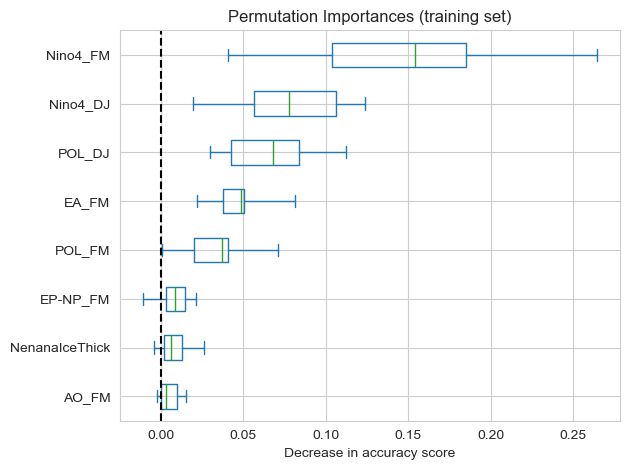

In [ ]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_train.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

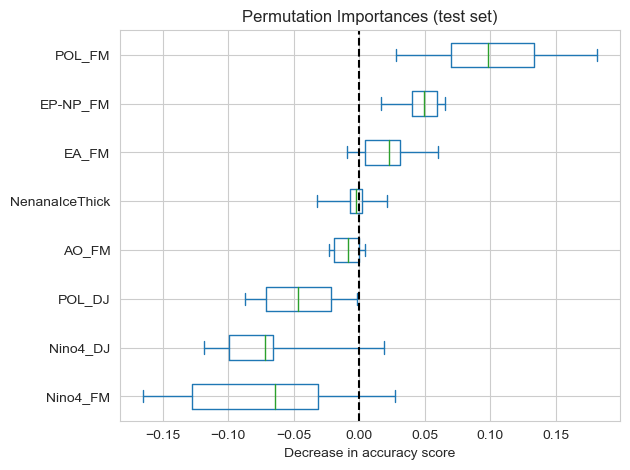

In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_test.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
sns.set_style('whitegrid')

The mean squared error (MSE) on train set: 21.9552
The mean squared error (MSE) on test set: 42.3467
The score for this training set is 0.4851
The validation score for this test set is -0.2206
Pearson score on training set: 0.7698
Pearson score on test set: 0.1217



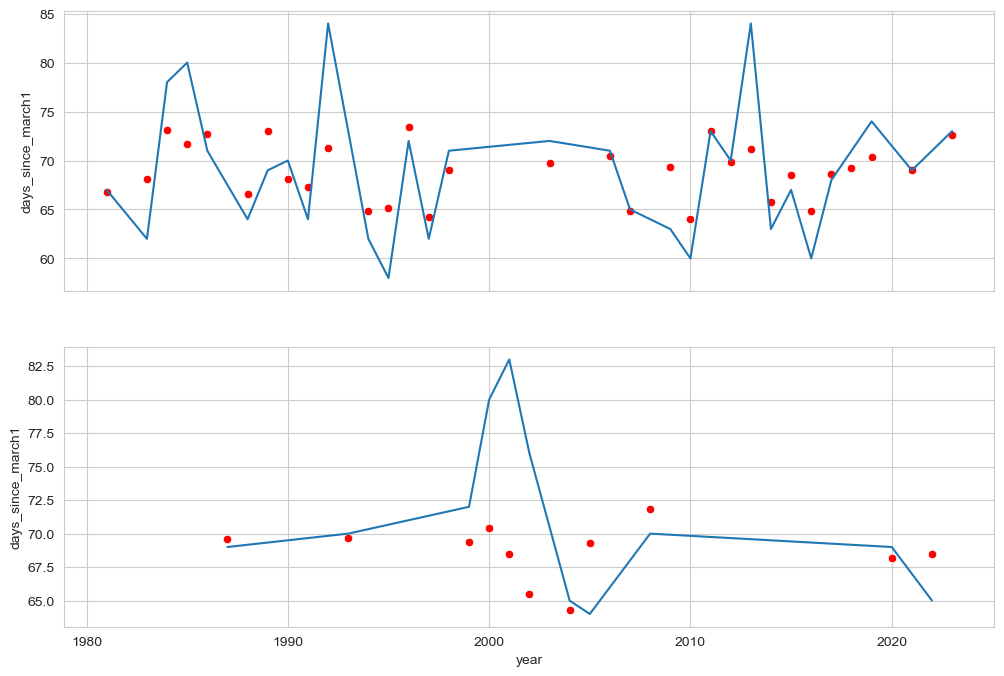

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)
model = best_model

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='blue', ax=ax)
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, color='red', ax=ax)
# ax.set_box_aspect(1)
plt.show(fig)

In [ ]:
X_test

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1993,0.474,1.165,0.145,0.075,-0.925,0.540,1.685,26.000000
2005,-1.309,0.010,0.875,0.640,-0.505,-0.575,0.145,32.000000
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1999,-0.505,-0.925,-1.580,-1.495,-1.825,-0.030,-0.620,46.000000
2000,0.312,-0.475,-1.345,-1.450,-0.135,-0.675,-1.535,37.700000
2002,1.103,0.550,0.260,0.355,1.030,-0.075,-0.350,48.000000
2001,-1.155,-0.450,-0.920,-0.765,0.420,0.025,-0.915,38.800000
2008,0.762,-1.010,-1.285,-1.465,0.315,-0.415,0.095,45.600000
2022,0.924,-0.275,-0.555,-0.530,0.835,-0.775,-1.075,31.250000
2004,-0.605,-0.890,0.430,0.240,0.765,-0.105,-1.165,35.500000


In [ ]:
best_model.fit(X_new, y)
prediction = best_model.predict(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
since_date = dt.datetime.strptime('202403011200', "%Y%m%d%H%M")
preddate = (since_date + dt.timedelta(days=prediction.item())).date().strftime("%Y-%m-%d")

summary['prediction_2024'] = prediction.item()
summary['pred_date_2024'] = preddate

preddate



# ru.dayssince2date(prediction.item())

'2024-05-05'

In [ ]:
summary

{'location': 'Koyukuk River at Bettles',
 'predictors': ['AO_FM',
  'EP-NP_FM',
  'Nino4_DJ',
  'Nino4_FM',
  'EA_FM',
  'POL_DJ',
  'POL_FM',
  'NenanaIceThick'],
 'modelparams': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.001,
  'loss': 'squared_error',
  'max_depth': 3,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 2000,
  'n_iter_no_change': None,
  'random_state': 40,
  'subsample': 0.5,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'rms_cv': 6.584772157246977,
 'rms_std_cv': 3.5896859626895004,
 'prediction_2024': 65.37169367143437,
 'pred_date_2024': '2024-05-05'}

### Shaply analysis

In [ ]:
import shap

In [ ]:
X_sample = shap.utils.sample(X_new, 50)

In [ ]:
X_test

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1993,0.474,1.165,0.145,0.075,-0.925,0.540,1.685,26.000000
2005,-1.309,0.010,0.875,0.640,-0.505,-0.575,0.145,32.000000
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1999,-0.505,-0.925,-1.580,-1.495,-1.825,-0.030,-0.620,46.000000
2000,0.312,-0.475,-1.345,-1.450,-0.135,-0.675,-1.535,37.700000
2002,1.103,0.550,0.260,0.355,1.030,-0.075,-0.350,48.000000
2001,-1.155,-0.450,-0.920,-0.765,0.420,0.025,-0.915,38.800000
2008,0.762,-1.010,-1.285,-1.465,0.315,-0.415,0.095,45.600000
2022,0.924,-0.275,-0.555,-0.530,0.835,-0.775,-1.075,31.250000
2004,-0.605,-0.890,0.430,0.240,0.765,-0.105,-1.165,35.500000


In [ ]:
explainer = shap.Explainer(best_model.predict, X_new)
shap_values = explainer(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
shap_values_all = explainer(X_new)
explainer2 = shap.Explainer(best_model.predict, X_test)
shap_values_test = explainer2(X_test)
sample_ind = 20

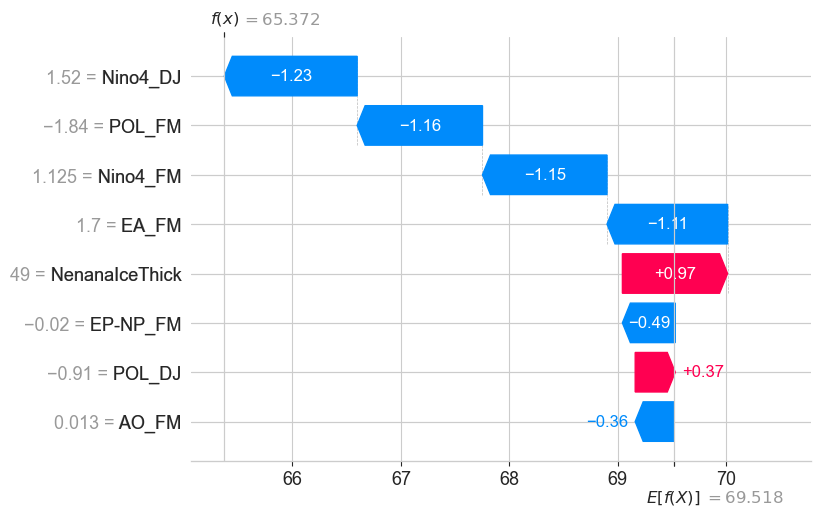

In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=20, show=False)
# ax.set_title(f"2024, {location}")
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_waterfall_2024.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

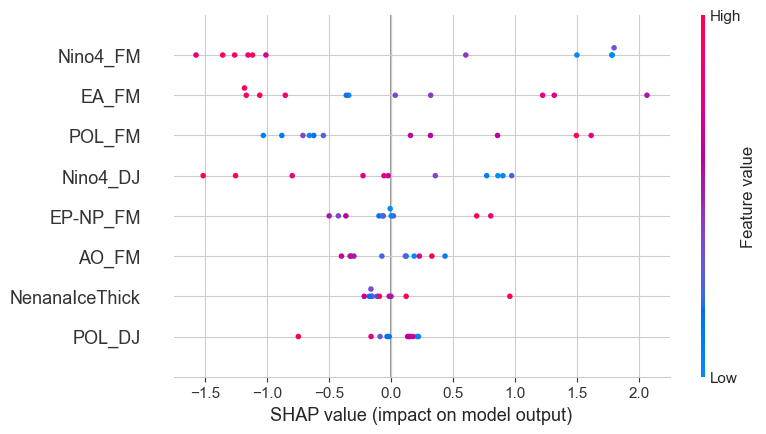

In [ ]:
shap.plots.beeswarm(shap_values_test, max_display=25)

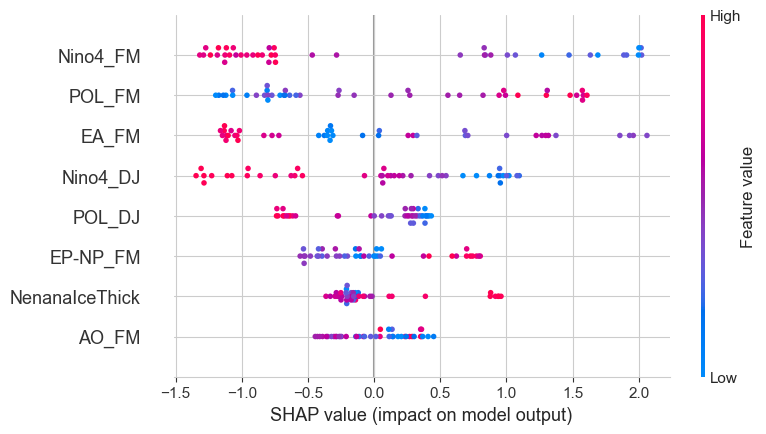

In [ ]:
shap.plots.beeswarm(shap_values_all, max_display=25, show=False)

if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_beehive.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
if saveplots:

    modeldir = ML_LOC / 'models'
    filename = f"{location.replace(' ', '_')}_joblib_model.sav"
    joblib.dump(model, modeldir / filename)
    summarydir =ML_LOC / 'model_eval'
    summaryfn = f"{location.replace(' ', '_')}_modelsummary.json"
    with open(summarydir / summaryfn, 'w' ) as dst: 
        json.dump(summary, dst, indent=2)
